# Differential stability 
`Limma` is originally design for micro-array experiments which is mainly doing same task as `DESeq2`.  Comparing to RNA expression analysis, RNA stability may have negetive values; `DESeq2` does not support negetive values but `Limma` does. Therefore, we decided to use `Limma` package instead of `DESeq2` for differential analysis. 

I've learned how to use limma from this [DataCamp course | differential-expression-analysis-with-limma-in-r](https://campus.datacamp.com/courses/differential-expression-analysis-with-limma-in-r/). 
However, I found these links useful while browsing. 
- http://genomicsclass.github.io/book/pages/using_limma.html
- https://bioconductor.org/packages/release/workflows/vignettes/RNAseq123/inst/doc/limmaWorkflow.html

In [1]:
import os
import subprocess
import glob
import warnings
import pandas as pd
import numpy as np

from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R
suppressMessages(suppressWarnings(library(edgeR)))
suppressMessages(suppressWarnings(library(Biobase)))
suppressMessages(suppressWarnings(library(rtracklayer)))
suppressMessages(suppressWarnings(library(tidyverse)))
suppressMessages(suppressWarnings(library(ggrepel)))
suppressMessages(suppressWarnings(library(patchwork)))

In [4]:
%%R 
run_norm <- function(eset){
    eset_norm <- eset
    # Log tranform
    exprs(eset_norm) <- log(exprs(eset_norm))
    # Quantile normalize
    exprs(eset_norm) <- normalizeBetweenArrays(exprs(eset_norm))
    
    return(eset_norm)
}
    
run_limma <- function(eset,design, cm){
    # Fit coefficients 
    fit <- lmFit(eset, design)
    # Fit contrasts 
    fit2 <- contrasts.fit(fit, contrasts = cm)
    # Calculate t-statistics 
    fit2 <- eBayes(fit2)
    return (fit2)
}

get_res<- function(fit,coef){
    res <- cbind(
        fit[,coef]$coef [,coef] %>% data.frame %>% rename(log2FoldChange='.'),
        fit[,coef]$p.value [,coef] %>% data.frame %>% rename(pvalue='.'),
        fit$genes %>% data.frame %>% select(name)
    )
    return(res)
}

boxplot_top_hit <- function (eset,gene_name){
    gene = (fData(eset) %>% rownames_to_column('row'))$row[fData(eset)$name == gene_name]
    # Create a boxplot of a given gene
    boxplot(exprs(eset)[gene, ] ~ pData(eset)[, "cond"],main = fData(eset)[gene, "name"])
    boxplot(exprs(eset)[gene, ] ~ pData(eset)[, "time"],main = fData(eset)[gene, "name"])
}


In [5]:
%%R 
plot_volcano <- function(res, lfc.cutoff  = 1,pval.cutoff = 0.05, title=''){
    res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)
    ## Volcano plot
    vol = res %>% ggplot(
        aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
    #         xlim(c(-20,20)) +
    #         ylim(c(0,11)) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(legend.position="none",plot.title = element_text(hjust = 0.5,face = "bold")) +
            ggtitle (title) + 
            geom_text_repel(
                data = subset(res[order(res$pvalue),], sig == TRUE)[1:5,],
                aes(label = name),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            ) 
    
     return (vol)
}

Read gene annotations into R 

In [6]:
%%R
GTF = '/rumi/shams/genomes/hg38/hg38_ensemble_genes.gtf'

gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')

Make meta table:

In [7]:
%%R
# meta table
treats  <- rep(c(rep('DMSO',2), rep('treated',2)),3)
reps    <- rep(c('rep1','rep2'),6)
hours   <- c(rep('6h',4),rep('72h',4),rep('120h',4))
hours = factor (hours, levels = c("6h", "72h", "120h"))

samples = paste(hours, treats, reps, sep='_')
group = paste(hours, treats, sep='.')

meta <- data.frame(
    time=factor(hours), 
    cond=factor(treats),
    group=factor(group),
    sample_id=samples,
    row.names=samples)
meta$cond <- relevel(meta$cond, ref='DMSO')
meta$group <- relevel(meta$group, ref='6h.DMSO')
meta$time


 [1] 6h   6h   6h   6h   72h  72h  72h  72h  120h 120h 120h 120h
Levels: 6h 72h 120h


#### REMoving Bias from Rna-seq ANalysis of Differential Transcript Stability
[REMBRANDTS](https://github.com/csglab/REMBRANDTS) is a package for analysis of RNA-seq data across multiple samples in order to obtain unbiased estimates of differential mRNA stability. It uses DESeq to obtain estimates of differential pre-mRNA and mature mRNA abundance across samples, and then estimates a gene-specific bias function that is then subtracted from Δexon–Δintron to provide unbiased differential mRNA stability measures.



In [8]:
# Read `REMBRANDTS` results
stbl = pd.read_csv('../REMBRANDTS.txt', sep='\t',index_col='GeneID')

In [9]:
%%R -i stbl
stbl = stbl %>% select(paste0('X', rownames(meta)))
colnames(stbl) <- rownames(meta)

# Make annotation dataframe 
ann = data.frame(
    name=gene2name[rownames(stbl),],
    row.names=rownames(stbl)
)

# Create ExpressionSet object
eset <- ExpressionSet(
    assayData = as.matrix(stbl),
    phenoData = AnnotatedDataFrame(meta),
    featureData = AnnotatedDataFrame(ann)
)

In [10]:
%%R 
# Create design matrix
design <- model.matrix(~0 + cond + group, pData(eset))
# Count the number of samples modeled by each coefficient
colSums(design)

         condDMSO       condtreated    group120h.DMSO group120h.treated 
                6                 6                 2                 2 
  group6h.treated     group72h.DMSO  group72h.treated 
                2                 2                 2 


In [11]:
%%R 
cm = makeContrasts(
    # contrast design: treatment at 120h vs dmso at 120h
    hl60_120h = condtreated - condDMSO + group120h.treated - group120h.DMSO,
    # # contrast design: treatment at 72h vs dmso at 72h
    # hl60_72h  = condtreated - condDMSO + group72h.treated - group72h.DMSO,
    # contrast design: treatment at 6h vs dmso at 6h
    hl60_6h   = condtreated - condDMSO + group6h.treated,
    levels = design
)

In [12]:
%%R 
fit <- eset %>% 
# run_norm %>% 
run_limma (design, cm)

Coefficients not estimable: group72h.treated 


I don't understand why "Coefficients not estimable: group72h.treated"!

## Principal Component Analysis (PCA)
Just like the RNA-seq experssion analysis, sample `72h_treated_rep2` comes up as an outlier. Removing that from the analysis give us a better representation. Therfore, we can see that treated samples at 6h cluster with the non-treated samples which suggest that 6 hours treatment with the drug is not as effective as 72h and 120h. Although, we will check the variant genes in this time-point in the following statistical analysis.


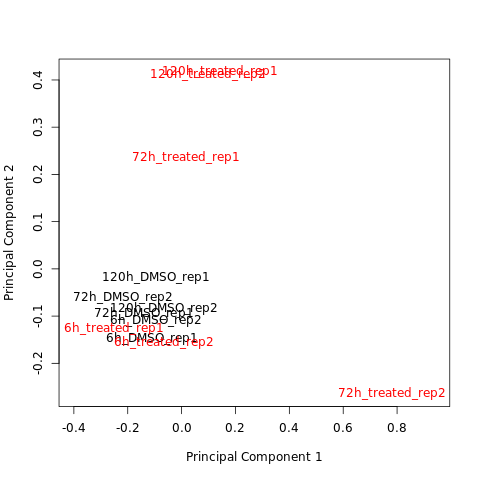

In [24]:
%%R 
# Plot principal components labeled by treatment
col_by_cond=rep(c(rep("black",2), rep("red",2)),3)
plotMDS(eset, labels = pData(eset)[, "sample_id"], col=col_by_cond, gene.selection = "common")

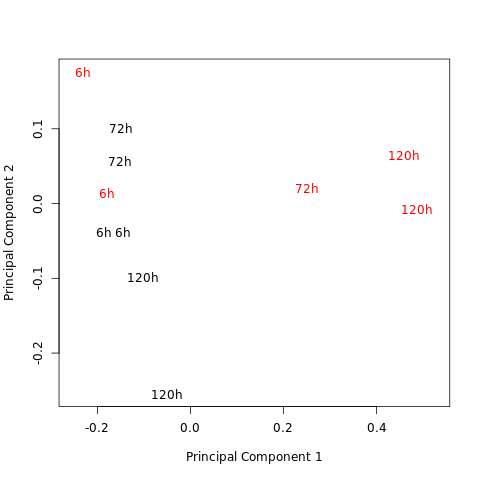

In [25]:
%%R 
# Plot principal components labeled by treatment
filter = !eset@phenoData@data$sample_id == '72h_treated_rep2'
plotMDS(eset[,filter], labels = pData(eset[,filter])[, "time"], col=col_by_cond[filter], gene.selection = "common")

## Normalizing and filtering


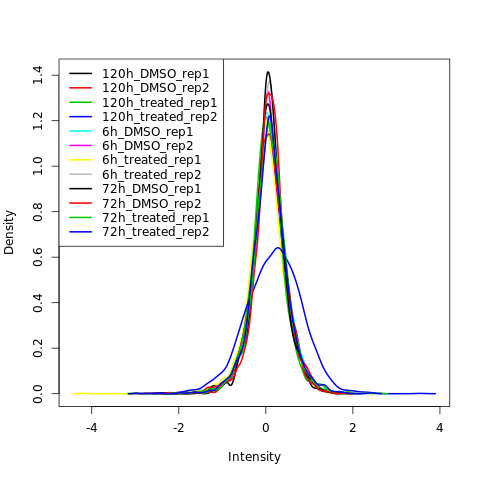

In [26]:
%%R 
# Create new ExpressionSet to store normalized data
eset_norm <- eset
# View the distribution of the raw data
p0 = plotDensities(eset_norm) #, legend = FALSE)

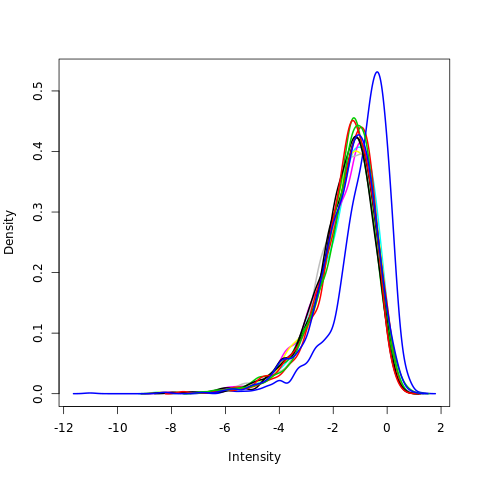

In [27]:
%%R
# Log tranform
exprs(eset_norm) <- log(exprs(eset_norm))
plotDensities(eset_norm, legend = FALSE)

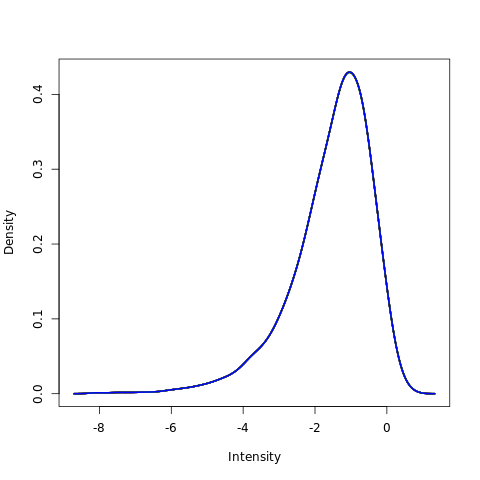

In [28]:
%%R
# Quantile normalize
exprs(eset_norm) <- normalizeBetweenArrays(exprs(eset_norm))
plotDensities(eset_norm, legend = FALSE)

Let's write normalized RNA-Stabilities into a file. 

In [29]:
%%R 
# replace NA with 0 (?!)
ncu <- exprs(eset_norm) #%>% replace_na(0)
write.table(ncu,'hl60_stbl_norm_log_quantile.txt', sep="\t", quote=FALSE, col.names=TRUE)

ncu %>% summary

  6h_DMSO_rep1      6h_DMSO_rep2     6h_treated_rep1   6h_treated_rep2  
 Min.   :-8.0913   Min.   :-8.0913   Min.   :-8.0913   Min.   :-8.0913  
 1st Qu.:-2.0951   1st Qu.:-2.0950   1st Qu.:-2.0950   1st Qu.:-2.0950  
 Median :-1.3292   Median :-1.3292   Median :-1.3292   Median :-1.3292  
 Mean   :-1.5441   Mean   :-1.5441   Mean   :-1.5443   Mean   :-1.5441  
 3rd Qu.:-0.7532   3rd Qu.:-0.7532   3rd Qu.:-0.7532   3rd Qu.:-0.7532  
 Max.   : 0.7174   Max.   : 0.7174   Max.   : 0.7174   Max.   : 0.7174  
 NA's   :1166      NA's   :1118      NA's   :1328      NA's   :1072     
 72h_DMSO_rep1     72h_DMSO_rep2     72h_treated_rep1  72h_treated_rep2 
 Min.   :-8.0913   Min.   :-8.0913   Min.   :-8.0913   Min.   :-8.0913  
 1st Qu.:-2.0950   1st Qu.:-2.0950   1st Qu.:-2.0951   1st Qu.:-2.0950  
 Median :-1.3292   Median :-1.3292   Median :-1.3292   Median :-1.3292  
 Mean   :-1.5442   Mean   :-1.5442   Mean   :-1.5442   Mean   :-1.5440  
 3rd Qu.:-0.7532   3rd Qu.:-0.7532   3rd Qu.:-0.753

what kind of p-value will be the right one to identify differentially expressed genes
https://www.biostars.org/p/18470/

https://support.bioconductor.org/p/7084/

In [21]:
# %%R 
# select_thr <- function (adj){
#     x <- -log10(adj)
#     plot(x, type="l")
#     sigline <- c(.05, .01, .005, .001,.0005, .0001)
#     sigline <- -log10(sigline)
#     sigcolors <- c("red", "blue", "green", "yellow","pink","purple")
#     sapply(1:length(sigline), function(x){abline(h=sigline[x], col=sigcolors[x])})
# }

In [ ]:
# %%R 
# select_thr(stats_120h$adj.P.Val)

In [22]:
# %%R 
# select_thr(stats_6h$adj.P.Val)

In [34]:
# %%R 
# # Obtain the summary statistics 
# stats_120h <- topTable(fit, coef = "hl60_120h", adjust.method="fdr", number = nrow(fit),
#                               sort.by = "none")

# # Create histograms of the p-values for each contrast
# hist(stats_120h[, "P.Value"])

In [32]:
# %%R 
# # Obtain the summary statistics 
# stats_6h <- topTable(fit2, coef = "hl60_6h", number = nrow(fit2),
#                               sort.by = "none")

# # Create histograms of the p-values for each contrast
# hist(stats_6h[, "P.Value"])

In [35]:
%%R 
fit <- eset %>% run_limma (design, cm)
fit_norm <- eset  %>% run_norm %>% run_limma (design, cm) 

res_6h      <- get_res(fit,'hl60_6h') 
res_norm_6h <- get_res(fit_norm,'hl60_6h') 

res_120h      <- get_res(fit,'hl60_120h') 
res_norm_120h <- get_res(fit_norm,'hl60_120h') 

Coefficients not estimable: group72h.treated 
Coefficients not estimable: group72h.treated 


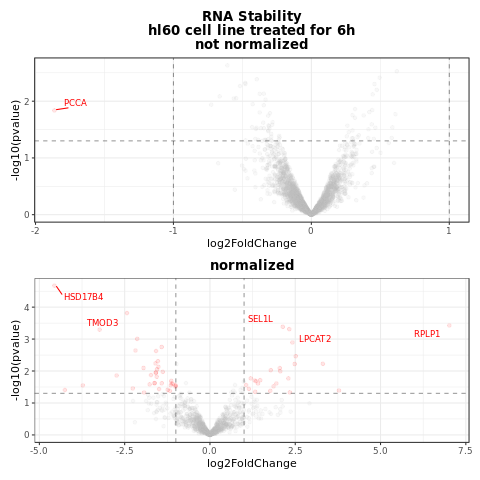

In [44]:
%%R 
p1 = res_6h %>% 
plot_volcano (title='RNA Stability\nhl60 cell line treated for 6h\nnot normalized')

p2 = res_norm_6h %>% 
plot_volcano (title='normalized')

p3 = res_120h %>% 
plot_volcano (title='RNA Stability\nhl60 cell line treated for 120h\nnot normalized')

p4 = res_norm_120h %>% 
plot_volcano (title='normalized')

(p1 / p2)

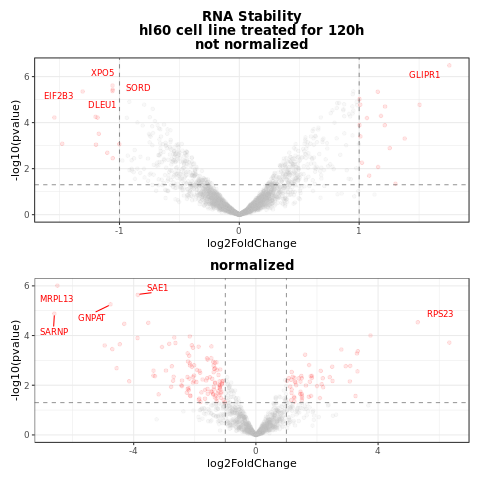

In [45]:
%%R 
(p3 / p4)

___

#### 72h only

In [15]:
%%R 
# Create ExpressionSet object
eset_72h <- ExpressionSet(
    assayData = as.matrix(stbl %>% select(contains("72h_"))),
    phenoData = AnnotatedDataFrame(meta[meta$time == '72h',]),
    featureData = AnnotatedDataFrame(ann)
)

# Create design matrix
design_72h <- model.matrix(~0 + cond, pData(eset_72h))

cm_72h = makeContrasts(
    # contrast design: treatment at 72h vs dmso at 72h
    hl60_72h  = condtreated - condDMSO,
    levels = design_72h
)

fit_72h <- eset_72h  %>% run_limma (design_72h, cm_72h) 
fit_norm_72h <- eset_72h  %>% run_norm %>% run_limma (design_72h, cm_72h) 

res_72h      <- get_res(fit_72h,'hl60_72h') 
res_norm_72h <- get_res(fit_norm_72h,'hl60_72h') 

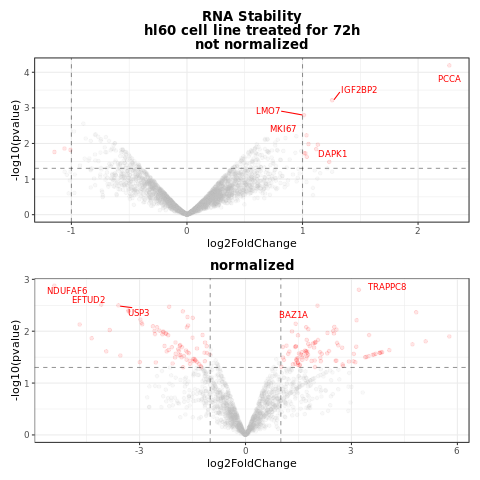

In [17]:
%%R 
p1 = res_72h %>% 
plot_volcano (title='RNA Stability\nhl60 cell line treated for 72h\nnot normalized')

p2 = res_norm_72h %>% 
plot_volcano (title='normalized')

p1 / p2

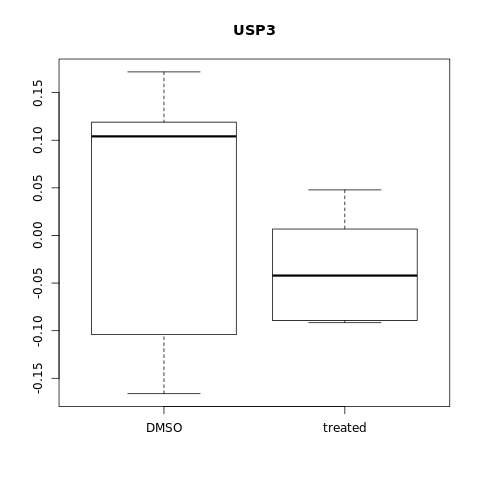

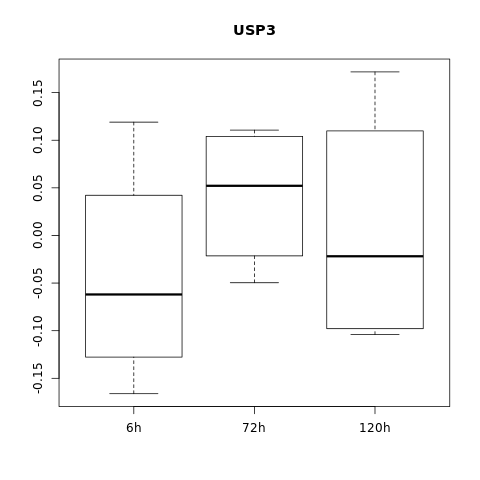

In [23]:
%%R 
boxplot_top_hit(eset, 'USP3')

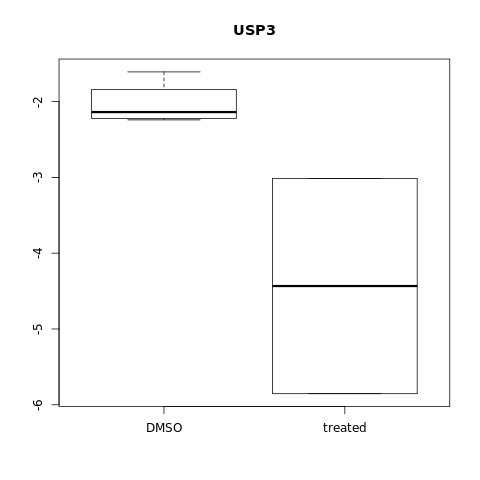

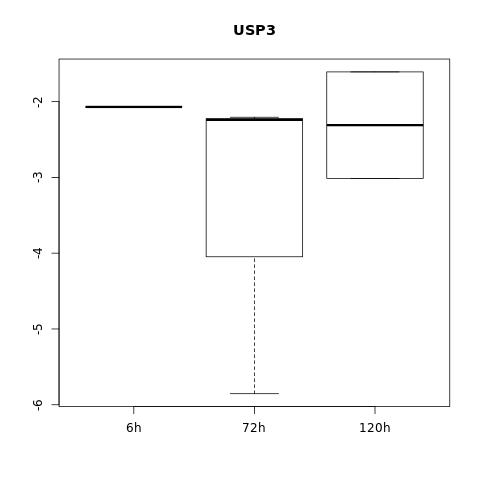

In [22]:
%%R 
boxplot_top_hit(eset %>% run_norm, 'USP3')

___

# Write result tables into file

Here, I write all results into files which includes log2FoldChange and p.values for contrasts at hour 6 and hour 120, plus gene names and gene ids. 

In [234]:
%%R 
cbind(
    res_norm_6h   %>% dplyr::mutate(log2FoldChange = replace_na(log2FoldChange, 0)) %>% select(log2FoldChange,pvalue) %>% rename(hl60.6h.stbl.log2FoldChange = log2FoldChange,hl60.6h.stbl.pvalue = pvalue),
    res_norm_72h  %>% dplyr::mutate(log2FoldChange = replace_na(log2FoldChange, 0)) %>% select(log2FoldChange,pvalue) %>% rename(hl60.72h.stbl.log2FoldChange = log2FoldChange,hl60.72h.stbl.pvalue = pvalue),
    res_norm_120h %>% rownames_to_column %>% dplyr::mutate(log2FoldChange = replace_na(log2FoldChange, 0)) %>% rename(hl60.120h.stbl.log2FoldChange = log2FoldChange,hl60.120h.stbl.pvalue = pvalue)
) %>% column_to_rownames('rowname') -> results

In [235]:
%%R 
# results 
write.table(results, 
            'hl60_delta_stbl_table.txt', quote = F, col.names=TRUE, row.names=TRUE,sep ='\t')

## Enrichment analysis

Write iGET friendly tables:

In [93]:
%%R 
write.table(results[,c('name','hl60.6h.stbl.log2FoldChange')] , 'hl60_6h_delta_stbl.txt', 
            quote = F, col.names=FALSE, row.names=FALSE,sep ='\t')
write.table(results[,c('name','hl60.72h.stbl.log2FoldChange')] , 'hl60_72h_delta_stbl.txt', 
            quote = F, col.names=FALSE, row.names=FALSE,sep ='\t')
write.table(results[,c('name','hl60.120h.stbl.log2FoldChange')] , 'hl60_120h_delta_stbl.txt', 
            quote = F, col.names=FALSE, row.names=FALSE,sep ='\t')

In [80]:
# %%R 
# goana(fit_norm_72h)
# # Extract the entrez gene IDs
# entrez <- rownames(fit_norm_72h$genes) 
# # Test for enriched KEGG Pathways
# enrich_kegg <- kegga(fit_norm_72h, geneid = entrez, species = 'Hs')

## Clustering 

In [100]:
%%R 
df_sig = results %>% rownames_to_column %>% 
    filter (
        hl60.72h.stbl.log2FoldChange > 1 & hl60.72h.stbl.pvalue < 0.05 
#         P.Value_120h   < 0.001 |
#         adj.P.Val_6h   < 0.05 
#         adj.P.Val_120h < 0.05)
           ) %>% 
    remove_rownames %>% column_to_rownames('rowname') 

df_sig %>% head

                hl60.6h.stbl.log2FoldChange hl60.6h.stbl.pvalue
ENSG00000000419                   0.4710950           0.4503606
ENSG00000009790                   0.3747981           0.4315288
ENSG00000013573                   0.0000000                  NA
ENSG00000026297                  -0.2934718           0.6618489
ENSG00000035928                   0.0000000                  NA
ENSG00000039319                   0.0000000                  NA
                hl60.72h.stbl.log2FoldChange hl60.72h.stbl.pvalue
ENSG00000000419                     1.484091          0.040400839
ENSG00000009790                     1.411794          0.042508719
ENSG00000013573                     2.482625          0.009878875
ENSG00000026297                     2.365655          0.024161149
ENSG00000035928                     1.739704          0.030334310
ENSG00000039319                     1.483714          0.044568616
                hl60.120h.stbl.log2FoldChange hl60.120h.stbl.pvalue     name
ENSG000000004

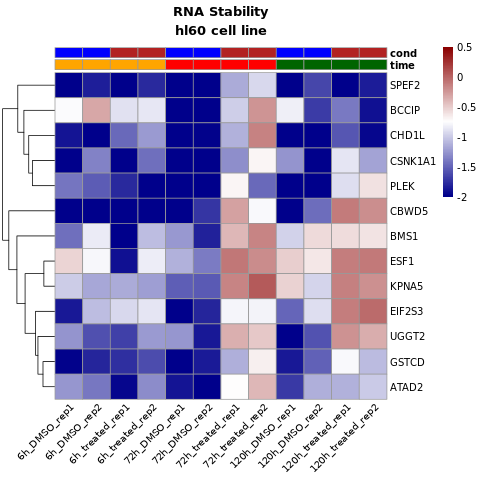

In [163]:
%%R 
library(RColorBrewer)
library(pheatmap)

# Subset normalized counts to significant genes
sig_norm_counts <- ncu[rownames(df_sig),] 
rownames(sig_norm_counts) <- df_sig$name
sig_norm_counts <- sig_norm_counts %>% data.frame %>% drop_na()
colnames(sig_norm_counts) <- rownames(meta)

ann_colors = list(cond = c('DMSO'="darkgreen", 'treated'="firebrick"))

# Choose heatmap color palette
heat_colors <- brewer.pal(n = 6, name = "YlOrRd")
colors <- c(seq(-2,0.5,by=0.01)) # ,max(sig_norm_counts))
my_palette <- c("darkblue",colorRampPalette(colors = c("darkblue", "white", "darkred"))
                                                   (n = length(colors)-3), "red")

ann_colors = list(
    cond = c('DMSO'="blue", 'treated'="firebrick"),
    time = c('120h'= "darkgreen", '72h'="red", '6h'="orange")
)

# Plot heatmap
h = pheatmap(
    sig_norm_counts, 
    cluster_cols = F, 
    main = 'RNA Stability\nhl60 cell line',
    cluster_rows = T, 
    show_rownames = T,
    annotation = select(meta, time, cond), 
    # scale = 'row', 
    angle_col= 45,
    annotation_legend=F,
    color = my_palette, 
    breaks = colors,

    annotation_colors = ann_colors
)


In [132]:
%%R 
# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('plots/Heatmap_clustering_top.pdf', width=7, height=7)
grid::grid.newpage()
grid::grid.draw(h$gtable)
dev.off()

png 
  2 


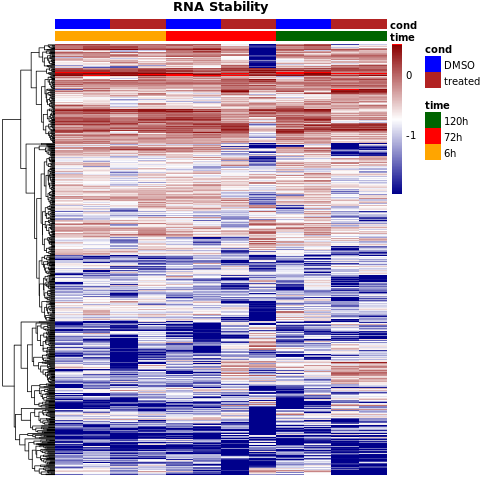

In [168]:
%%R 
# Subset normalized counts to significant genes
sig_norm_counts <- ncu[rowSums(ncu) != 0,] %>% data.frame %>% drop_na()
rownames(sig_norm_counts) = ann[rownames(sig_norm_counts),]

colnames(sig_norm_counts) <- rownames(meta)

# Plot heatmap
h2 = pheatmap(sig_norm_counts, 
         cluster_cols = F, 
         cluster_rows = T, 
         show_rownames = F,
         show_colnames = F,
         main = 'RNA Stability',
         annotation = select(meta, time, cond), 
         # scale = 'row', 
         color = my_palette, 
         breaks = colors,margin = c(-2,2),
         angle_col= 45,
         legend_breaks = -1:1,
         # annotation_legend=F,
         annotation_colors = ann_colors
            )

In [169]:
%%R 
# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('plots/Heatmap_clustering.pdf', width=7, height=7)
grid::grid.newpage()
grid::grid.draw(h2$gtable)
dev.off()

png 
  2 


# 5 other cell lines 

In [181]:
%%R 
# meta 
lines   <- lapply(c('kg1', 'molm14', 'ociaml2', 'ociaml3', 'thp1'), rep, 6) %>% unlist 
treats  <- rep(c(rep('treated',3), rep('DMSO',3)),5)
treats0 <- rep(c(rep('t',3), rep('u',3)),5)
reps    <- rep(c('rep1','rep2','rep3'),5)
reps0   <- rep(c('1','2','3'),5)

meta <- data.frame(
    line=lines, 
    cond=treats, 
    row.names=paste(lines, treats0, reps0, sep='_'),
    stringsAsFactors=FALSE
)

In [182]:
%%R -i stbl
stbl = stbl %>% select(rownames(meta))
colnames(stbl) <- rownames(meta)

# Make annotation dataframe 
ann = data.frame(
    name=gene2name[rownames(stbl),],
    row.names=rownames(stbl)
)

# Create ExpressionSet object
eset <- ExpressionSet(
    assayData = as.matrix(stbl),
    phenoData = AnnotatedDataFrame(meta),
    featureData = AnnotatedDataFrame(ann)
)

In [196]:
%%R 
# kg1 cell line
e <- eset[,meta$line == "kg1"]
d <- model.matrix(~0 + cond, pData(e))
# contrast design
cm <- makeContrasts(kg1= condtreated - condDMSO,levels = d)
fit_kg1 <- e %>% run_norm %>% run_limma (d, cm)
res_kg1 <- get_res(fit_kg1,'kg1') 

In [197]:
%%R 
# molm14 cell line
e <- eset[,meta$line == "molm14"]
d <- model.matrix(~0 + cond, pData(e))
# contrast design
cm <- makeContrasts(molm14= condtreated - condDMSO,levels = d)
fit_molm14 <- e %>% run_norm %>% run_limma (d, cm)
res_molm14 <- get_res(fit_molm14,'molm14') 

In [203]:
%%R 
# ociaml2 cell line
e <- eset[,meta$line == "ociaml2"]
d <- model.matrix(~0 + cond, pData(e))
# contrast design
cm <- makeContrasts(ociaml2= condtreated - condDMSO,levels = d)
fit_ociaml2 <- e %>% run_norm %>% run_limma (d, cm)
res_ociaml2 <- get_res(fit_ociaml2,'ociaml2') 

In [204]:
%%R 
# ociaml3 cell line
e <- eset[,meta$line == "ociaml3"]
d <- model.matrix(~0 + cond, pData(e))
# contrast design
cm <- makeContrasts(ociaml3= condtreated - condDMSO,levels = d)
fit_ociaml3 <- e %>% run_norm %>% run_limma (d, cm)
res_ociaml3 <- get_res(fit_ociaml3,'ociaml3') 

In [206]:
%%R 
# thp1 cell line
e <- eset[,meta$line == "thp1"]
d <- model.matrix(~0 + cond, pData(e))
# contrast design
cm <- makeContrasts(thp1= condtreated - condDMSO,levels = d)
fit_thp1 <- e %>% run_norm %>% run_limma (d, cm)
res_thp1 <- get_res(fit_thp1,'thp1') 

## Principal Component Analysis (PCA)

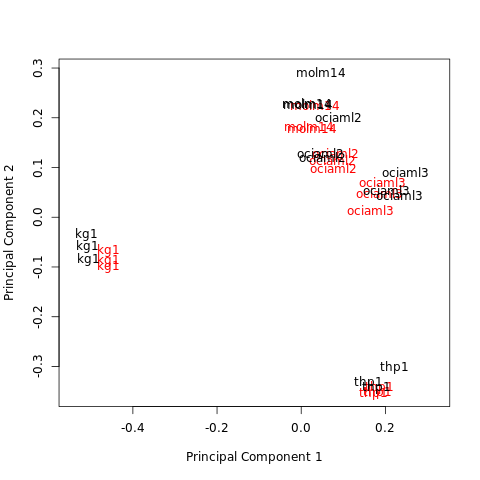

In [213]:
%%R 
# Plot principal components labeled by treatment
col_by_cond=rep(c(rep("red",3), rep("black",3)),5)
plotMDS(eset, labels = pData(eset)[, "line"], col=col_by_cond, gene.selection = "common")

In [217]:
%%R 
lines %>% unique

[1] "kg1"     "molm14"  "ociaml2" "ociaml3" "thp1"   


In [228]:
%%R 
p1 = res_kg1 %>% 
plot_volcano (title='RNA Stability\nkg1 cell line')

p2 = res_molm14 %>% 
plot_volcano (title='molm14 cell line')

p3 = res_ociaml2 %>% 
plot_volcano (title='ociaml2 cell line')

p4 = res_ociaml3 %>% 
plot_volcano (title='ociaml3 cell line')

p5 = res_thp1 %>% 
plot_volcano (title='thp1 cell line')

p1$labels$x <- p2$labels$x <- p3$labels$x <- p4$labels$x <- " "


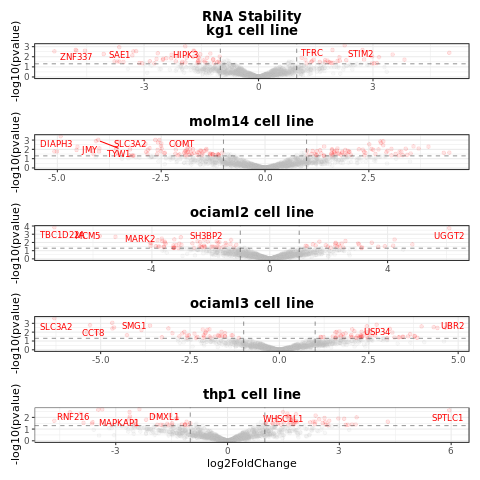

In [229]:
%%R 
(p1 / p2 / p3 / p4 / p5) + plot_layout(widths = c(1, 25))

In [244]:
%%R 
cbind(
    res_kg1     %>% dplyr::mutate(log2FoldChange = replace_na(log2FoldChange, 0)) %>% select(log2FoldChange,pvalue) %>% rename(kg1.stbl.log2FoldChange = log2FoldChange,kg1.stbl.pvalue = pvalue),
    res_molm14  %>% dplyr::mutate(log2FoldChange = replace_na(log2FoldChange, 0)) %>% select(log2FoldChange,pvalue) %>% rename(molm14.stbl.log2FoldChange = log2FoldChange,molm14.stbl.pvalue = pvalue),
    res_ociaml2 %>% dplyr::mutate(log2FoldChange = replace_na(log2FoldChange, 0)) %>% select(log2FoldChange,pvalue) %>% rename(ociaml2.stbl.log2FoldChange = log2FoldChange,ociaml2.stbl.pvalue = pvalue),
    res_ociaml3 %>% dplyr::mutate(log2FoldChange = replace_na(log2FoldChange, 0)) %>% select(log2FoldChange,pvalue) %>% rename(ociaml3.stbl.log2FoldChange = log2FoldChange,ociaml3.stbl.pvalue = pvalue),
    res_thp1    %>% dplyr::mutate(log2FoldChange = replace_na(log2FoldChange, 0)) %>% select(log2FoldChange,pvalue) %>% rename(thp1.stbl.log2FoldChange = log2FoldChange,thp1.stbl.pvalue = pvalue),
    res_norm_72h  %>% rownames_to_column %>% dplyr::mutate(log2FoldChange = replace_na(log2FoldChange, 0)) %>% rename(hl60.72h.stbl.log2FoldChange = log2FoldChange,hl60.72h.stbl.pvalue = pvalue)
) %>% column_to_rownames('rowname') -> results

## Enrichment analysis

Write iGET friendly tables:

In [245]:
%%R 
for (line in lines %>% unique){
    write.table(results[,c('name',paste0(line,'.stbl.log2FoldChange') )] , paste0('../other-stbl/',line,'_delta_stbl.txt'), 
                quote = F, col.names=FALSE, row.names=FALSE,sep ='\t')
}

___

In [170]:
%%R 
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] pheatmap_1.0.12      RColorBrewer_1.1-2   patchwork_1.0.0     
 [4] ggrepel_0.8.1        forcats_0.4.0        stringr_1.4.0       
 [7] dplyr_0.8.3          purrr_0.3.3          readr_1.3.1         
[10] tidyr_1.0.0          tibble_2.1.3         ggplot2_3.2.1  

In [171]:
!date

Wed Nov 10 01:07:30 UTC 2021
